# Household Power Consumption Forecasting
## (Supplementary Notebook)
Compiled by Leo R. De Velez

This supplementary notebook applies the methodology used in the M5 Forecasting notebook, the LightGBM, on the Household Power Consumption dataset. In this supplementary notebook, we will be forecasting the household daily power consumption for the next 30 days.
<br><br>
Most of the codes on this supplementary notebook  were copied from the previous notebook of this chapter, the "Winningest Methods in Time Series Forecasting", that was compiled by Sebastian C. Ibañez. Marwell Dalangin also provided some data preparation codes.  
<br>
Some of the codes from the previous notebook were removed, replaced, or modified and some new codes were added as needed by Leo R. De Velez.

## 1. Import the Python Modules

Import the necessary python modules.

In [1]:
## Copied from previous notebook and modified as needed

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.multioutput import MultiOutputRegressor

## 2. Load the Household Power Consumption Dataset

The Household Power Consumption Dataset can be downloaded from Kaggle website through the following URL link:
<br>
https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?select=household_power_consumption.txt
<br><br>
Read the previously downloaded dataset in a zip file format in as a csv data array.

In [2]:
## Provided by Marwell Dalangin and modified as needed

## Download the data from
## https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?
## select=household_power_consumption.txt

data_source = 'data/household_power_consumption.txt.zip'
df = pd.read_csv(data_source,
     sep=';',
     parse_dates={'dt': ['Date', 'Time']},
     infer_datetime_format=True,
     low_memory=False,
     na_values=['nan', '?'],
     index_col='dt')
df.columns = [x.lower() for x in df.columns]

# features
relevant_columns = [
    "global_active_power", "global_reactive_power", "voltage",
    "global_intensity", "sub_metering_1", "sub_metering_2",
    "sub_metering_3"
    ]

# Handling missing values
for every_column in relevant_columns:
    df[every_column] = df[every_column].interpolate()

# Computation for overall power consumtion
eq1 = (df['global_active_power'] * 1000 / 60)
eq2 = df['sub_metering_1'] + \
    df['sub_metering_2'] + df['sub_metering_3']
df['power_consumption'] = eq1 - eq2
relevant_columns = df.columns

# Aggregating level: "M" - Monthly, "W" - Weekly, "D" - Daily, "H" - Hourly
df = df[relevant_columns].resample("D").sum()
df = df['power_consumption']

## 3. Examine the Dataset

Print and plot the dataset.

<bound method NDFrame.head of             power_consumption
dt                           
2006-12-16       14680.933333
2006-12-17       36946.666667
2006-12-18       19028.433333
2006-12-19       13131.900000
2006-12-20       20384.800000
...                       ...
2010-11-22       16924.600000
2010-11-23       16352.266667
2010-11-24       13769.466667
2010-11-25       17278.733333
2010-11-26       13347.733333

[1442 rows x 1 columns]>
DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='dt', length=1442, freq='D')


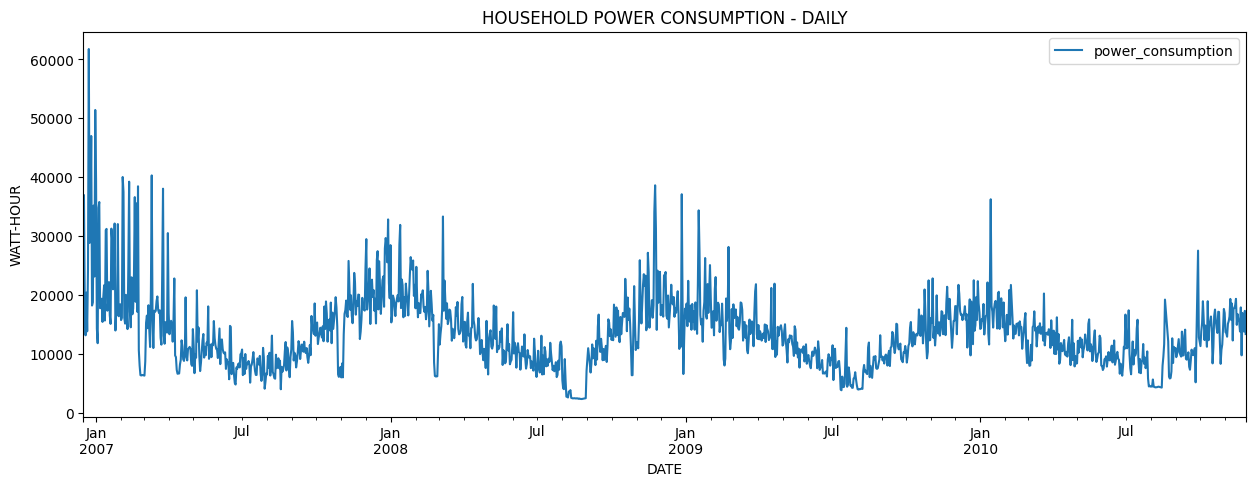

In [3]:
## Copied from previous notebook and modified as needed

series = pd.DataFrame(df)
print(series.head)
print(series.index)

plot_x_size = 15
plot_y_size = 5 
plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
np.set_printoptions(precision = 6, suppress = True)
series.plot()
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DATE")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 4. Define the Data Preparation

Define the procedure for slicing the datasets into arrays of Independent and Dependent Variables.

In [4]:
## Copied from previous notebook and modified as needed

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

## 5. Prepare the Training and Testing Datasets

Split the x and y arrays into training and testing datasets

In [5]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN TEST SPLIT ### 
test_size = int(len(series)*0.2)
split_time = len(series) - test_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1124, 30)
(1124,)
(288, 30)
(288,)


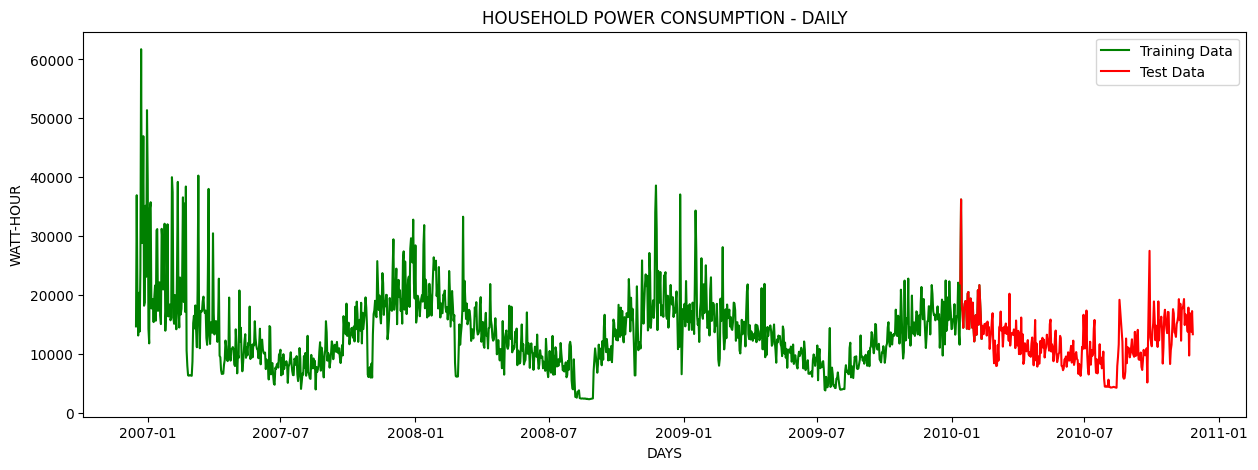

In [6]:
## Show the split of data from training, validation, and testing.

plt.plot(train_series, color='green', label = 'Training Data')
plt.plot(test_series, color='red', label = 'Test Data')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 6. Build the LightGBM Model

In [7]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 7. Forecast and Compare with Test Data

In [8]:
## Check the forecasting accuracy of LightGBM

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2053.4269
  LightGBM MAPE : 17.9951
  LightGBM RMSE : 2836.7399


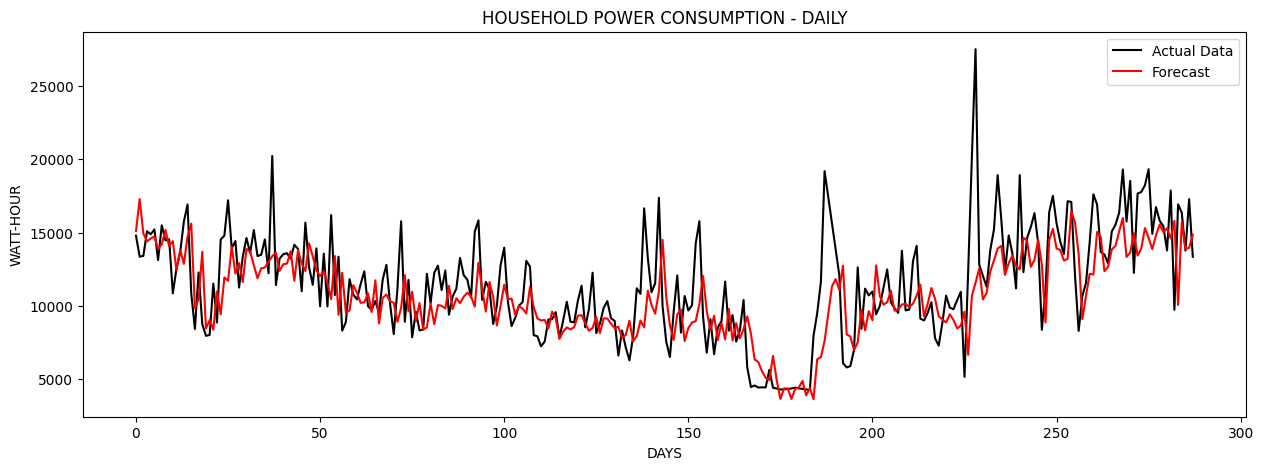

In [9]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 8. Compare Forecast Accuracy with Benchmarks

Compare the forecasting accuracy of the LightGBM with Naive and Seasonal Naive.
<br>
The LightGBM forecast output was based on the text_x dataset input.
<br>
The LightGBM forecast output was compared with the text_y actual data.
<br>
The errors were computed as MAE and MAPE.  These were compared with the benchmarks,

In [10]:
## Copied from previous notebook and modified as needed

s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 5065.6564
  s7-Naive MAE: 4868.4466
 s30-Naive MAE: 4263.9096
s365-Naive MAE: 5550.8436
  LightGBM MAE: 2053.4269

     Naive MAPE: 59.7888
  s7-Naive MAPE: 56.8506
 s30-Naive MAPE: 49.1670
s365-Naive MAPE: 64.5304
  LightGBM MAPE: 17.9951


## 9. Tune the LightGBM Hyperparameters

Determine the best window setting for the LightGBM model.

  7 --- MAE: -2850.172 (334.388)
 14 --- MAE: -2705.636 (252.812)
 21 --- MAE: -2643.173 (265.699)
 30 --- MAE: -2628.932 (327.081)
 45 --- MAE: -2548.489 (268.616)
 90 --- MAE: -2387.937 (260.795)
180 --- MAE: -2418.128 (235.835)
365 --- MAE: -2390.280 (268.008)


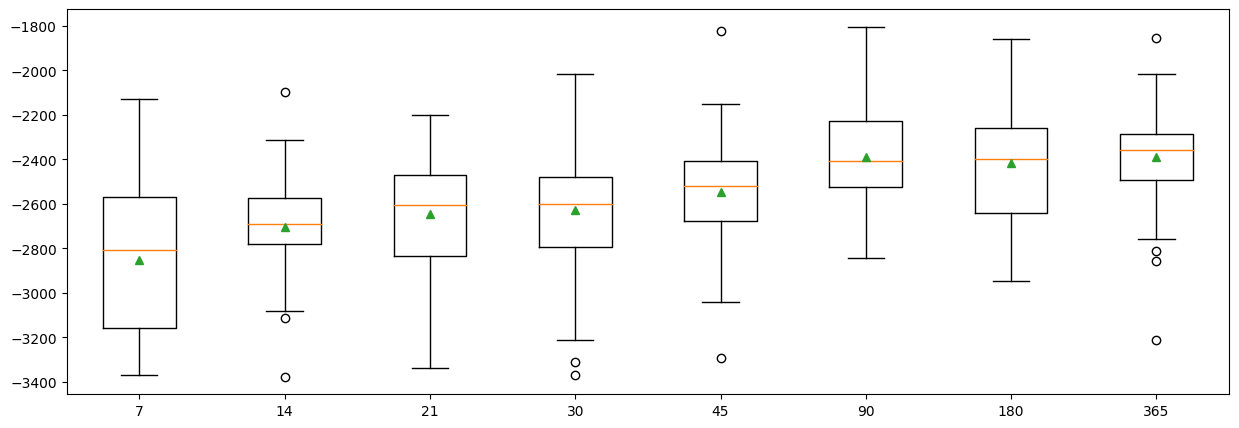

In [11]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}
windows = [7, 14, 21, 30, 45, 90, 180, 365]
results = []
names = []
for w in windows:
    window_size = w
    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
    train_y = train_y.flatten()
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

## 10. Adjust the Hyperparameters

Use the window size that produced the lowest Mean Absolute Error. Compare the resulting MAE.

In [12]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN TEST SPLIT ###
test_size = int(len(series)*0.2)
split_time = len(series) - test_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(974, 180)
(974,)
(288, 180)
(288,)


## 11. Re-Build the LightGBM 

In [13]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

## 12. Re-Forecast and Compare

In [14]:
## Re-Run the prediction model and check the resulting forecasting accuracy

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 1984.5134
  LightGBM MAPE : 17.2223
  LightGBM RMSE : 2732.6559


The LightRBM Mean Absolute Percent Error improved only a bit from about 18.25% down to about 17.27%.

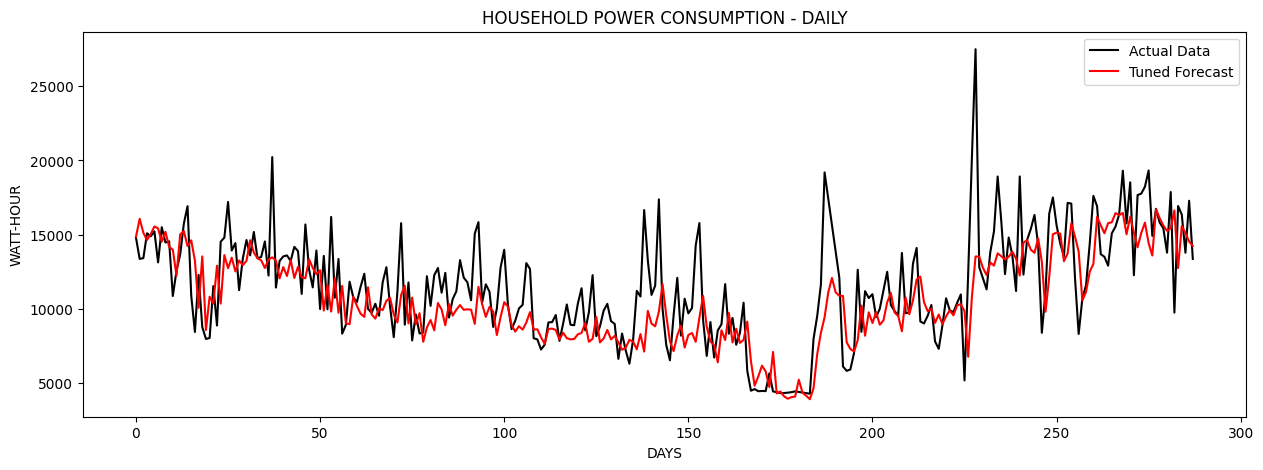

In [15]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='black', label = 'Actual Data')
plt.plot(forecast, color='red', label = 'Tuned Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

In [16]:
print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('')
print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 5065.6564
  s7-Naive MAE: 4868.4466
 s30-Naive MAE: 4263.9096
s365-Naive MAE: 5550.8436
  LightGBM MAE: 1984.5134

     Naive MAPE: 59.7888
  s7-Naive MAPE: 56.8506
 s30-Naive MAPE: 49.1670
s365-Naive MAPE: 64.5304
  LightGBM MAPE: 17.2223


## 13. Recursive Forecast compared with Test Dataset

Recursive Forecasting using the first element of the Test Data Set.  Then compare with the Test Dataset.

In [17]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN TEST SPLIT ### (include shuffling later)
test_size = int(len(series)*0.2)
split_time = len(series) - test_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(974, 180)
(974,)
(288, 180)
(288,)


In [18]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

            One-Step MAE : 1984.5134
Recursive Multi-Step MAE : 3078.4835

            One-Step MAPE: 17.2223
Recursive Multi-Step MAPE: 29.0007


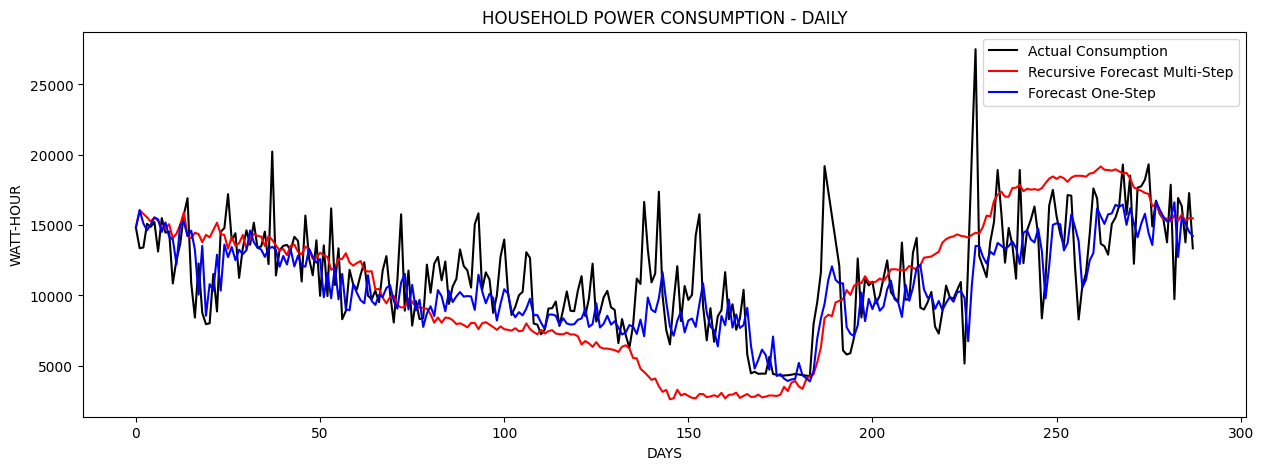

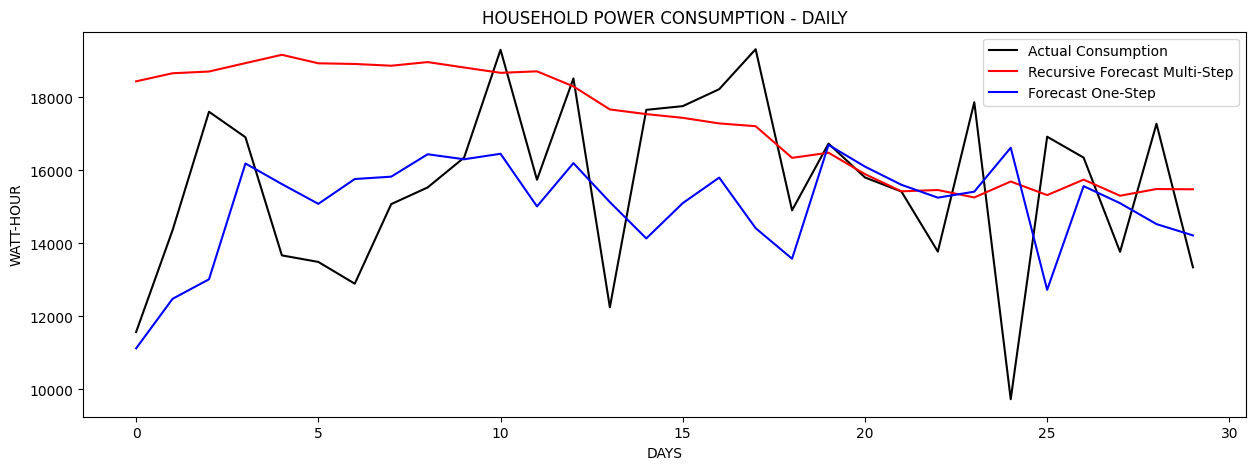

In [19]:
## Copied from previous notebook and modified as needed

recursive_x = test_x[0, :]

forecast_ms = []
#for i in range(test_x.shape[0]):
for i in range(test_x.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

print('            One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Recursive Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))
print('')
print('            One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os - test_y)/test_y*100)))
print('Recursive Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y)/test_y*100)))


plt.plot(test_y, color='black', label = 'Actual Consumption')
plt.plot(forecast_ms_rec, color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_os, color='blue', label = 'Forecast One-Step')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

plt.plot(test_y[-30:], color='black', label = 'Actual Consumption')
plt.plot(forecast_ms_rec[-30:], color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_os[-30:], color='blue', label = 'Forecast One-Step')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 14. Direct Forecast compared with Test Dataset

Direct Forecast using the first element of the Test Dataset and then compare with the Test Dataset.

In [20]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 30

### TRAIN TEST SPLIT ### 
test_size = int(len(series)*0.2)
split_time = len(series) - test_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

#train_y = train_y.flatten()
#test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(945, 180)
(945, 30)
(259, 180)
(259, 30)


In [21]:
## Copied from previous notebook and modified as needed

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

         One-Step MAE : 4575.2983
Direct Multi-Step MAE : 5764.5076

         One-Step MAPE: 56.1745
Direct Multi-Step MAPE: 69.2446


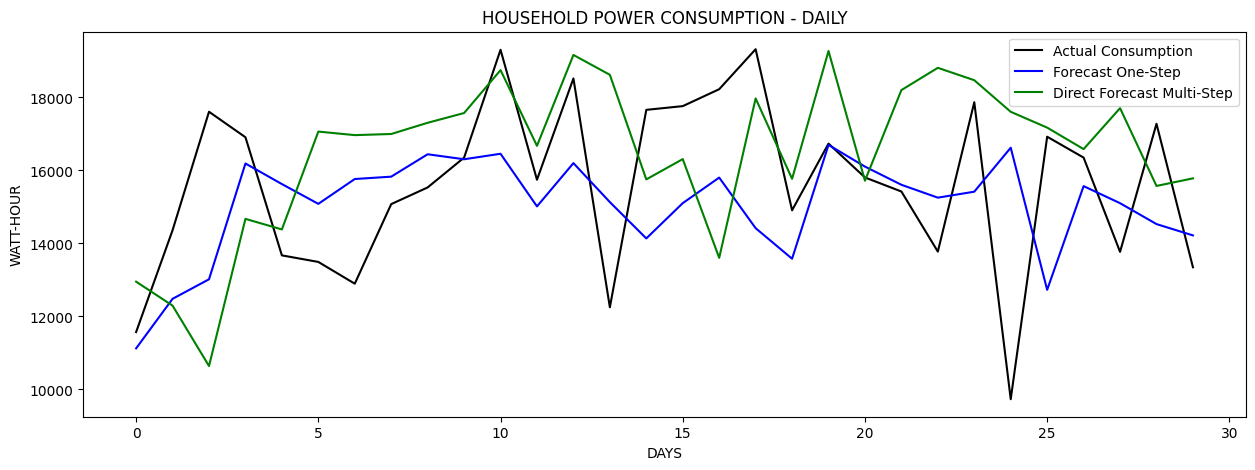

In [22]:
## Copied from previous notebook and modified as needed

forecast_ms_dir = model.predict(test_x[-1:])

print('         One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os[-30:] - test_y))))
print('Direct Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('')
print('         One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os[-30:] - test_y)/test_y*100)))
print('Direct Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y)/test_y*100)))

plt.plot(test_y[-1:].flatten(), color='black', label = 'Actual Consumption')
#plt.plot(forecast_ms_rec[-30:], color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_os[-30:], color='blue', label = 'Forecast One-Step')
plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()


## 15. Combined Recursive and Direct Forecasting

Combining Recursive and Direct Forecast with equal weights.

            One-Step MAE : 4575.2983
   Direct Multi-Step MAE : 5764.5076
Recursive Multi-Step MAE : 6398.9192
 Combined Multi-Step MAE : 5985.1704

            One-Step MAPE: 56.1745
   Direct Multi-Step MAPE: 69.2446
Recursive Multi-Step MAPE: 76.4970
 Combined Multi-Step MAPE: 72.2260


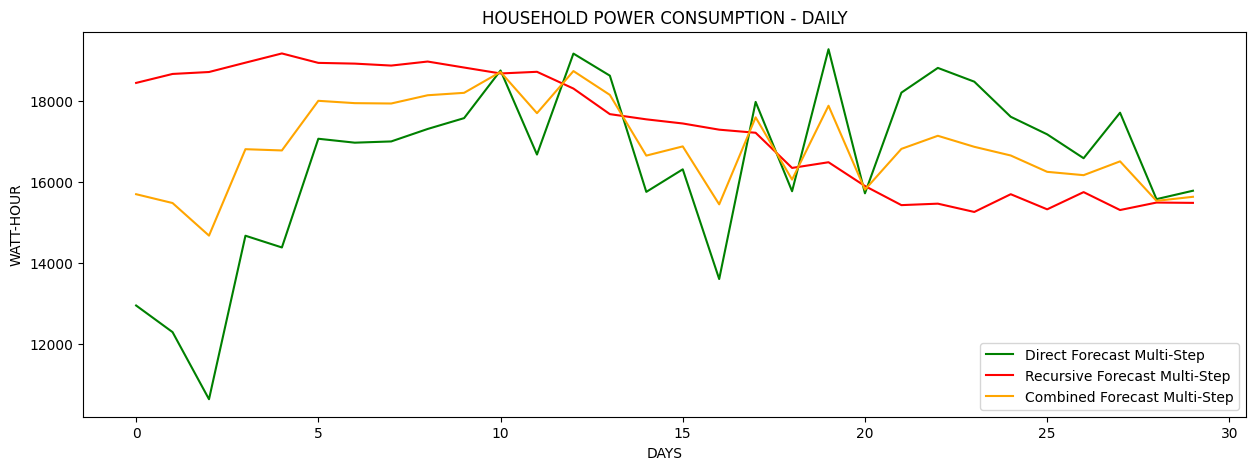

In [23]:
## Copied from previous notebook and modified as needed

forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec[-30:]

print('            One-Step MAE : %.4f' % (np.mean(np.abs(forecast_os[-30:] - test_y))))
print('   Direct Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))
print('Recursive Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_rec[-30:] - test_y))))
print(' Combined Multi-Step MAE : %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y))))
print('')
print('            One-Step MAPE: %.4f' % (np.mean(np.abs(forecast_os[-30:] - test_y)/test_y*100)))
print('   Direct Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y)/test_y*100)))
print('Recursive Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_rec[-30:] - test_y)/test_y*100)))
print(' Combined Multi-Step MAPE: %.4f' % (np.mean(np.abs(forecast_ms_comb - test_y)/test_y*100)))

#plt.plot(test_y[-1:].flatten(), color='black', label = 'Actual Consumption')
#plt.plot(forecast_os[-30:], color='blue', label = 'Forecast One-Step')
plt.plot(forecast_ms_dir.flatten(), color='green', label = 'Direct Forecast Multi-Step')
plt.plot(forecast_ms_rec[-30:], color='red', label = 'Recursive Forecast Multi-Step')
plt.plot(forecast_ms_comb, color='orange', label = 'Combined Forecast Multi-Step')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 16. Recursive Forecasting Beyond the Dataset

Recursive forecast starting with the last element of the Test Dataset.
Forecast one day ahead.
Then, add the new forcast to the latest element in the input dataset. 
Then, remove the oldest element from the input dataset.
Then, repeate the above process.

In [24]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = int(len(series)*0.2)
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1124, 30)
(1124,)
(288, 30)
(288,)


In [25]:
## Copied from previous notebook and modified as needed

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

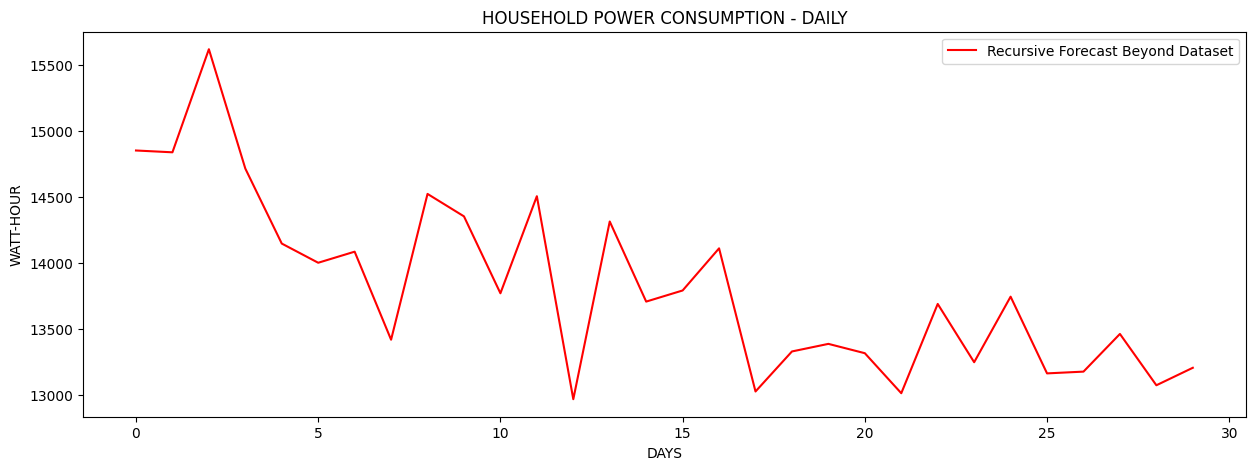

In [26]:
recursive = 30

recursive_x = test_x[-1, :]
forecast_ms = []
for i in range(recursive):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec_beyond = np.asarray(forecast_ms).flatten()

plt.plot(forecast_ms_rec_beyond, color='red', label = 'Recursive Forecast Beyond Dataset')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

## 17. Direct Forecasting Beyond the Dataset

Direct forecast using the last element of the Test Dataset.
Forecast multi-period ahead using the same last element of the Test Dataset.

In [27]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 30

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = int(len(series)*0.2)
split_time = len(series) - test_size
train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

#train_y = train_y.flatten()
#test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(1095, 30)
(1095, 30)
(259, 30)
(259, 30)


In [28]:
## Copied from previous notebook and modified as needed

model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs = -1)

model.fit(train_x, train_y)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

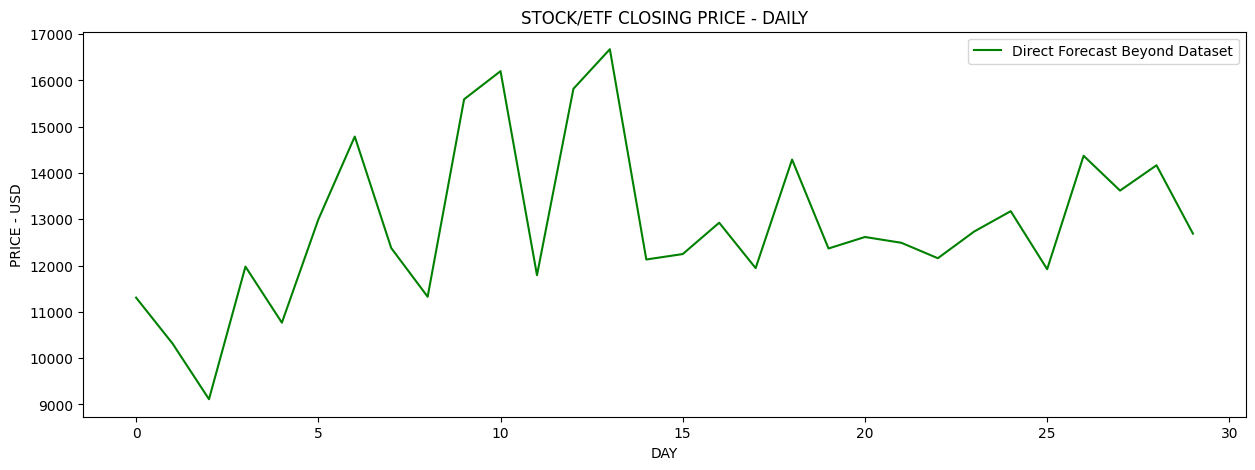

In [29]:
## Copied from previous notebook and modified as needed

forecast_ms_dir_beyond = model.predict(test_x[-1:])

plt.plot(forecast_ms_dir_beyond.flatten(), color='green', label = 'Direct Forecast Beyond Dataset')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 18. Combined Recursive and Direct Forecast Beyond Dataset

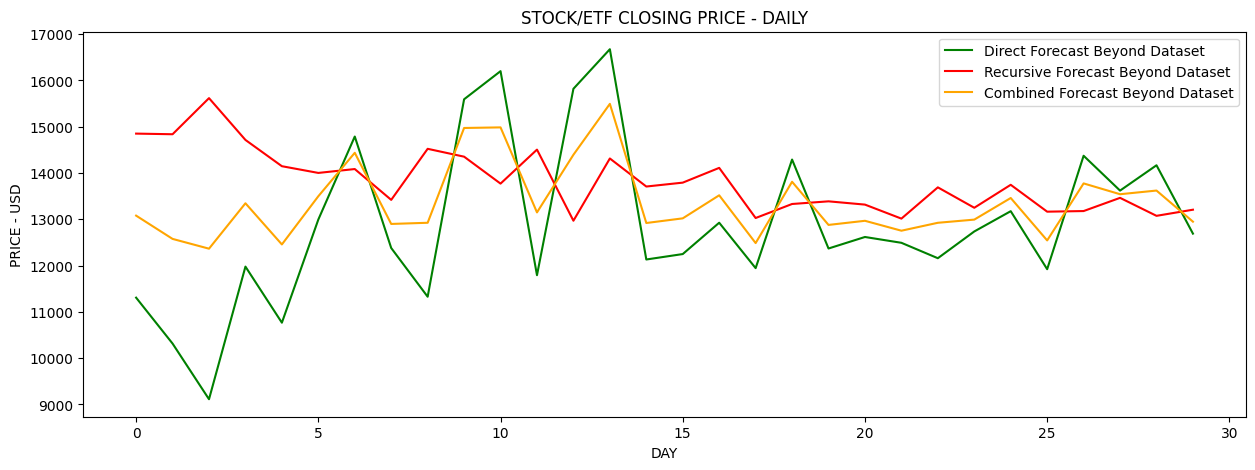

In [30]:
## Copied from previous notebook and modified as needed

forecast_ms_comb_beyond = 0.5*forecast_ms_dir_beyond.flatten() + 0.5*forecast_ms_rec_beyond

plt.plot(forecast_ms_dir_beyond.flatten(), color='green', label = 'Direct Forecast Beyond Dataset')
plt.plot(forecast_ms_rec_beyond, color='red', label = 'Recursive Forecast Beyond Dataset')
plt.plot(forecast_ms_comb_beyond, color='orange', label = 'Combined Forecast Beyond Dataset')
plt.title("STOCK/ETF CLOSING PRICE - DAILY")
plt.xlabel("DAY")
plt.ylabel("PRICE - USD")
plt.legend()
plt.show()

## 19. Feature Importance

Generate the feature importance metrics.

In [31]:
## Copied from previous notebook and modified as needed

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

### TRAIN TRAIN SPLIT ### 
test_size = window_size + prediction_horizon
split_time = len(series) - test_size

train_series = series.iloc[:split_time, 0]
test_series = series.iloc[split_time-window_size:, 0]

train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
test_x, test_y = create_xy(test_series, window_size, prediction_horizon)

train_y = train_y.flatten()
test_y = test_y.flatten()

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

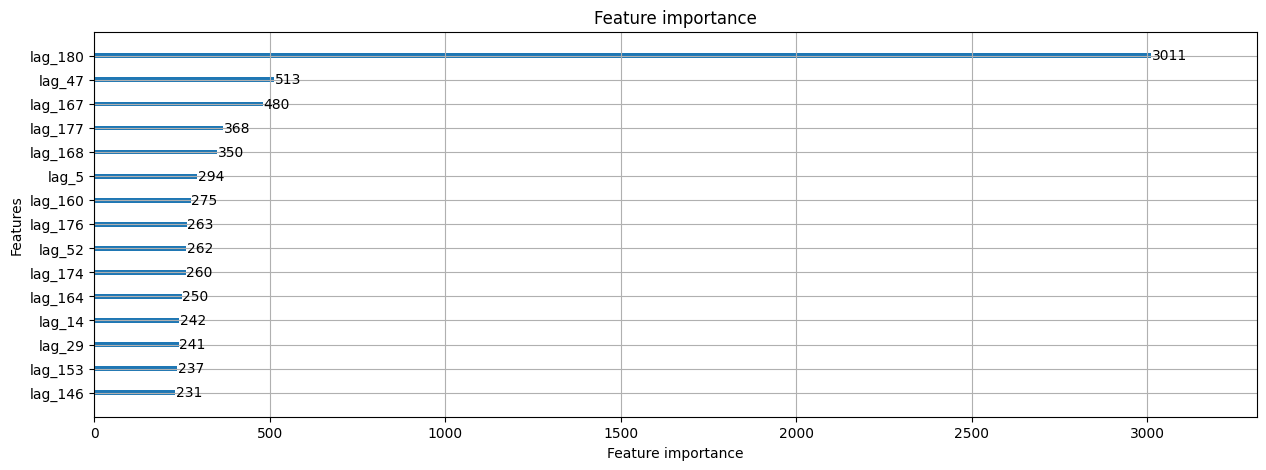

In [32]:
## Copied from previous notebook and modified as needed

lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()

## 20. Summary

In summary, this supplementary notebook demonstrated how to use the LightGBM, that was used by the winning team in the M5 Forecasting Competiton, for forecasting the Household Power Consumption.

The forecasting accuracy of the LighgGBM model used for forecasting the household power consumption was compared with Naive and Seasonal Naive forecast outputs.  Based on the comparison, the LightGMB forecasting accuracy for the household power consumption was significantly better. The forecasting accuracy of the LightGBM for the Household Power Consumption dataset is at around 17% Mean Absolute Percentage Error (MAPE) compared with the MAPE Naive and sNaive benchmarks for the same dataset of about 40% MAPE.

The tuning of the LightGBM model improved its forecasting accuracy just a bit from around 18.3% MAPE down to around 17.3% MAPE.

## 21. References

[1] S. Makridakis, E. Spiliotis, and V. Assimakopoulos. The M5 Accuracy competition: Results, findings and conlusions. 2020.

[2] S. Makridakis, E. Spiliotis, V. Assimakopoulos, Z. Chen, A. Gaba, I. Tsetlin, and R. Winkler. The M5 Uncertainty competition: Results, findings and conlusions. 2020.

[3] V. Jose, and R. Winkler. Evaluating quantile assessments. Operations research, 2009.

[4] A. Gaba, I. Tsetlin, and R. Winkler. Combining interval forecasts. Decision Analysis, 2017.